In [29]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.multioutput import MultiOutputRegressor
import pandas as pd
from scipy.optimize import minimize
import gurobipy as gp
from gurobipy import GRB
from typing import List, Tuple
from sklearn.svm import OneClassSVM
import time
from scipy.stats import truncnorm


In [30]:
def estimate_bounds(r_cur, r_next, q, delta):
    r_min = r_cur.min()
    r_max = r_cur.max()
    r_cur_bins = np.arange(r_min, r_max + delta, delta)

    # 最大値がビンに含まれるように調整
    if r_cur_bins[-1] < r_max or not np.isclose(r_cur_bins[-1], r_max):
        r_cur_bins = np.append(r_cur_bins, r_max)

    n_bins = len(r_cur_bins) - 1
    r_lb = np.full(n_bins, np.nan)
    r_ub = np.full(n_bins, np.nan)
    weights = np.full(n_bins, np.nan)

    # 各ビンに対して分位数を計算
    for i in range(n_bins):
        if i == n_bins - 1:
            # 最後のビンでは上限値を含める
            bin_mask = (r_cur >= r_cur_bins[i]) & (r_cur <= r_cur_bins[i + 1])
        else:
            bin_mask = (r_cur >= r_cur_bins[i]) & (r_cur < r_cur_bins[i + 1])

        r_next_in_bin = r_next[bin_mask]
        if len(r_next_in_bin) > 0:
            r_lb[i] = np.quantile(r_next_in_bin, q)
            r_ub[i] = np.quantile(r_next_in_bin, 1 - q)
            weights[i] = len(r_next_in_bin)

    # 有効なデータのみを取得
    valid_indices = ~np.isnan(r_lb) & ~np.isnan(r_ub)
    r_cur_bin_centers = r_cur_bins[:-1][valid_indices]
    r_lb = r_lb[valid_indices]
    r_ub = r_ub[valid_indices]
    weights = weights[valid_indices]

    return r_cur_bin_centers, r_lb, r_ub, weights


def plot_data(r_cur, r_next, r_cur_bin_centers, r_lb, r_ub, r_lb_adjusted, r_ub_adjusted, d):
    r_min = r_cur.min()
    r_max = r_cur.max()

    plt.figure(figsize=(10, 7))
    plt.scatter(r_cur, r_next, alpha=0.3, label="Operation data", color="orange", s=5)
    plt.plot(r_cur_bin_centers, r_lb, "b--", label="Estimated lower bound")
    plt.plot(r_cur_bin_centers, r_ub, "b--", label="Estimated upper bound")
    plt.plot(r_cur_bin_centers, r_lb_adjusted, "g-", label="Adjusted lower bound")
    plt.plot(r_cur_bin_centers, r_ub_adjusted, "g-", label="Adjusted upper bound")

    # 以前の直線を描くコードをコメントアウトまたは削除
    # plt.plot([r_min, r_max], [一定の値, 一定の値], "r-", label="直線")

    # 対角線を引くコードに変更
    # x_line = np.array([r_min, r_max])
    # y_line = x_line  # y = x の場合

    # plt.plot(x_line, y_line, "r-")

    plt.xlabel("Current profit margin (%)")
    plt.ylabel("Next profit margin (%)")
    plt.title("product " + str(d))
    plt.legend()
    plt.grid(True)
    plt.show()


def create_profit(N, r_cur, r_min, r_max, sigma_fraction, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # 平均値と標準偏差の計算
    mu = (r_min + r_max) / 2
    sigma = (r_max - r_min) * sigma_fraction  # 範囲の割合で標準偏差を設定
    # print("mu", mu, "sigma", sigma)

    # 標準正規分布に基づく利益率データの生成
    r_next = np.random.normal(loc=mu, scale=sigma, size=N)

    # 値がマイナスになった場合、0.001に置き換える
    r_next = np.where(r_next < 0, 0.001, r_next)

    r_pairs = []
    for i in range(N):
        r_pairs.append([r_cur, r_next[i]])

    return r_pairs


# alphaを作成する関数
def alpha_star(M: int) -> NDArray[np.float_]:
    alpha_star = np.random.uniform(M, 3 * M, size=M)
    return alpha_star


# betaを作成する関数
def beta_star(M: int, M_prime: int) -> NDArray[np.float_]:
    beta_star = np.zeros((M, M_prime))

    for m in range(M):
        for m_prime in range(M_prime):
            if m == m_prime:
                beta_star[m, m_prime] = np.random.uniform(-2 * M, -M)
            else:
                beta_star[m, m_prime] = np.random.uniform(0, 1)

    return beta_star


def quantity_function(
    price: NDArray[np.float_],
    alpha: NDArray[np.float_],
    beta: NDArray[np.float_],
    delta: float = 0.1,  # ノイズレベルを指定（例として0.1を使用）
) -> list[float]:
    M = len(price)
    quantity_list = []
    q_m_no_noise = []

    # ステップ1: ノイズなしのq_mを計算
    for m in range(M):
        sum_beta = 0
        for m_prime in range(M):
            sum_beta += beta[m][m_prime] * price[m_prime]
        quantity = alpha[m] + sum_beta
        q_m_no_noise.append(quantity)

    # E[q_m^2]を計算
    E_q_m_squared = np.mean(np.array(q_m_no_noise) ** 2)

    # ステップ2: ノイズの標準偏差sigmaを計算
    sigma = delta * np.sqrt(E_q_m_squared)

    # ステップ3: ノイズを加えて最終的なq_mを計算
    for m in range(M):
        epsilon = np.random.normal(0, sigma)
        quantity = q_m_no_noise[m] + epsilon
        quantity_list.append(quantity)

    return quantity_list


def creat_cost(d):
    # 0.6から1.0の範囲で0.1刻みのデータをランダムにd個生成
    cost = np.random.uniform(0.6, 1.0, d)
    cost = np.round(cost, 1)
    return cost


def creat_price(cost, proft):
    price = cost * (1 + proft)
    return price


def sales_function(
    price: NDArray[np.float_], alpha: NDArray[np.float_], beta: NDArray[np.float_]
) -> list[float]:
    M = len(price)
    sales_list = []

    for m in range(M):
        sum_beta = 0
        for m_prime in range(M):
            sum_beta += beta[m][m_prime] * price[m_prime]

        quantity = alpha[m] + sum_beta
        sales_list.append(quantity * price[m])

    return sales_list


In [31]:
def bounds_adjustment(r_cur_bin_centers, r_lb_hat, r_ub_hat, weights):
    n = len(r_cur_bin_centers)
    w = weights / np.sum(weights)

    # Gurobi のモデルを作成
    model = gp.Model()

    # 最適化変数を追加
    r_lb_vars = model.addVars(n, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="r_lb")
    r_ub_vars = model.addVars(n, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="r_ub")

    # 目的関数の定義
    objective = gp.QuadExpr()
    for i in range(n):
        # 下限の二乗誤差
        objective += w[i] * (r_lb_vars[i] - r_lb_hat[i]) ** 2
        # 上限の二乗誤差
        objective += w[i] * (r_ub_vars[i] - r_ub_hat[i]) ** 2

    model.setObjective(objective, GRB.MINIMIZE)

    # 制約条件の追加

    # 単調性の制約
    for i in range(1, n):
        model.addConstr(r_lb_vars[i] >= r_lb_vars[i - 1], name=f"monotonic_lb_{i}")
        model.addConstr(r_ub_vars[i] >= r_ub_vars[i - 1], name=f"monotonic_ub_{i}")

    # 下限の凸性
    for i in range(2, n):
        model.addConstr(
            (r_lb_vars[i] - r_lb_vars[i - 1]) >= (r_lb_vars[i - 1] - r_lb_vars[i - 2]),
            name=f"convex_lb_{i}",
        )

    # 上限の凹性
    for i in range(2, n):
        model.addConstr(
            (r_ub_vars[i] - r_ub_vars[i - 1]) <= (r_ub_vars[i - 1] - r_ub_vars[i - 2]),
            name=f"concave_ub_{i}",
        )

    # 上下限の順序
    for i in range(n):
        model.addConstr(r_lb_vars[i] <= r_ub_vars[i], name=f"order_{i}")

    # 最適化の実行
    model.optimize()

    # 結果の取得
    r_lb_adjusted = np.array([r_lb_vars[i].X for i in range(n)])
    r_ub_adjusted = np.array([r_ub_vars[i].X for i in range(n)])

    return r_lb_adjusted, r_ub_adjusted


In [32]:
# 目的関数を定義
def predict_objective_function(
    prices: NDArray[np.float_], intercepts: [float], coefs: [NDArray[np.float_]], M: int
) -> float:
    # 各変数の内容をデバッグ出力
    # print("prices:", prices)
    # print("intercepts:", intercepts)
    # print("coefs:", coefs)
    # print("M:", M)

    return -sum(
        prices[m]
        * (intercepts[m] + sum(coefs[m][m_prime] * prices[m_prime] for m_prime in range(M)))
        for m in range(M)
    )


# 予測と最適化を行う関数
def predict_optimize_Neldar(
    M: int, X: NDArray[np.float_], Y: NDArray[np.float_], initial_bounds, bounds
) -> tuple[float, NDArray[np.float_]]:
    lr = MultiOutputRegressor(LinearRegression())
    lr.fit(X, Y)
    # 係数と切片を取得
    coefs = [estimate.coef_ for estimate in lr.estimators_]
    intercepts = [estimate.intercept_ for estimate in lr.estimators_]

    # 最適化を実行
    result = minimize(
        predict_objective_function,
        initial_bounds,
        args=(intercepts, coefs, M),
        bounds=bounds,
        method="Nelder-Mead",
        options={"adaptive": True},
    )
    # 最適な価格と目的関数の値を取得
    optimal_prices = result.x
    optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す
    return optimal_value, optimal_prices


In [33]:
# 商品数を定義
d = 5

# ステップ1: 原価を決定
costs = creat_cost(d)
print("Costs:", costs)

# 需要量を計算するためのパラメータを生成
M = d  # 商品数
alpha = alpha_star(M)
beta = beta_star(M, M)
delta = 0.1  # delta の定義（需要量計算用）


# 各商品の利益率、価格、需要量を格納するリスト
profit_rates_list = []
prices = []
quantities = []
r_cur = np.arange(0.6, 1.01, 0.01)  # ステップ2: 各商品ごとに利益率、価格、需要量を計算
for i in range(d):
    # ステップ2-1: 利益率を決定

    N = 25
    sigma_fraction = 0.5

    # r_min と r_max を生成
    r_min = np.linspace(0.6, 0.8, len(r_cur))
    r_max = np.linspace(0.8, 1.0, len(r_cur))

    # r_pairs を生成（商品ごとに異なる）
    r_pairs = []
    for r, rmin, rmax in zip(r_cur, r_min, r_max):
        r_pairs.extend(create_profit(N, r, rmin, rmax, sigma_fraction))

    # r_pairs を利益率リストに追加
    profit_rates_list.append(r_pairs)

    price = np.array([pair[1] for pair in r_pairs])
    prices.append(price)


# prices を転置
prices = np.array(prices).T  # 形状は (時点数, 商品数)


Costs: [0.9 0.6 0.7 0.6 0.9]


In [34]:
# ステップ3: 需要量を計算
# 各時点での価格を使用して需要量を計算します
quantities = []

num_time_points = prices.shape[0]  # 時点の数

for t in range(num_time_points):
    # t 番目の時点での全商品の価格を取得
    price_at_t = prices[t]  # 形状は (商品数,)
    # 需要量を計算
    quantity_at_t = quantity_function(price_at_t, alpha, beta, delta)
    quantities.append(quantity_at_t)

# quantities を NumPy 配列に変換し、形状を (時点数, 商品数) にします
quantities = np.array(quantities)

X = np.array(prices)
y = quantities


In [35]:
# 予測区間の計算
q = 0.1
delta = 0.01
D = 5


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 199 rows, 82 columns and 476 nonzeros
Model fingerprint: 0x4a3940fd
Model has 82 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [3e-02, 5e-02]
  QObjective range [5e-02, 5e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.01s
Presolved: 199 rows, 82 columns, 476 nonzeros
Presolved model has 82 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 82
 AA' NZ     : 9.300e+02
 Factor NZ  : 2.667e+03
 Factor Ops : 3.989e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time

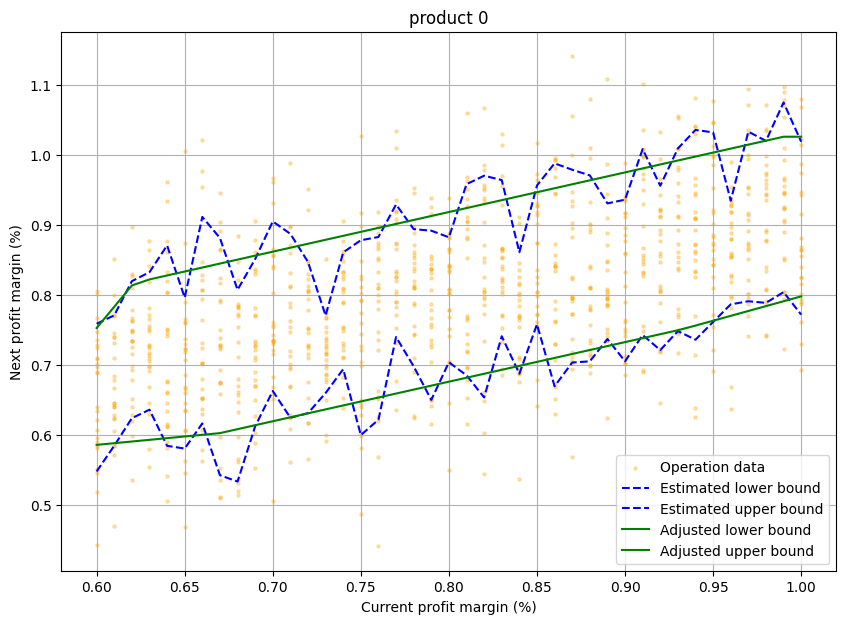

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 199 rows, 82 columns and 476 nonzeros
Model fingerprint: 0x09a6135c
Model has 82 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [3e-02, 5e-02]
  QObjective range [5e-02, 5e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.01s
Presolved: 199 rows, 82 columns, 476 nonzeros
Presolved model has 82 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 82
 AA' NZ     : 9.300e+02
 Factor NZ  : 2.667e+03
 Factor Ops : 3.989e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time

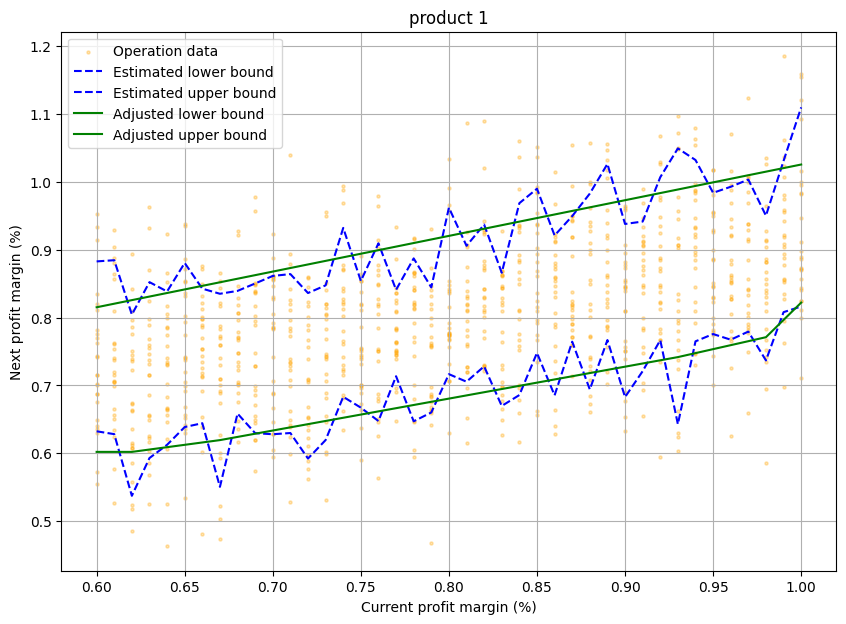

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 199 rows, 82 columns and 476 nonzeros
Model fingerprint: 0x5efd2814
Model has 82 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [3e-02, 5e-02]
  QObjective range [5e-02, 5e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.01s
Presolved: 199 rows, 82 columns, 476 nonzeros
Presolved model has 82 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 82
 AA' NZ     : 9.300e+02
 Factor NZ  : 2.667e+03
 Factor Ops : 3.989e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time

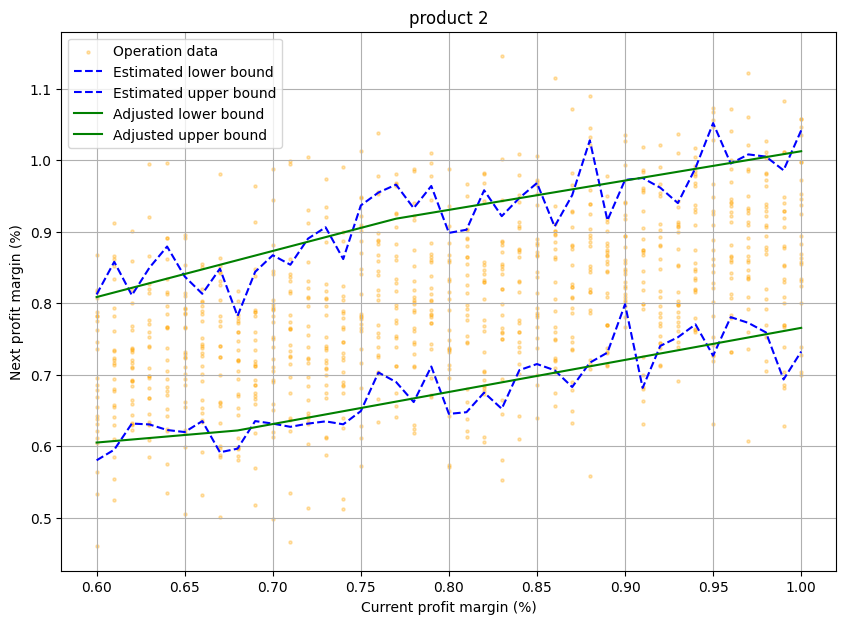

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 199 rows, 82 columns and 476 nonzeros
Model fingerprint: 0x93883ba1
Model has 82 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [3e-02, 5e-02]
  QObjective range [5e-02, 5e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.01s
Presolved: 199 rows, 82 columns, 476 nonzeros
Presolved model has 82 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 82
 AA' NZ     : 9.300e+02
 Factor NZ  : 2.667e+03
 Factor Ops : 3.989e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time

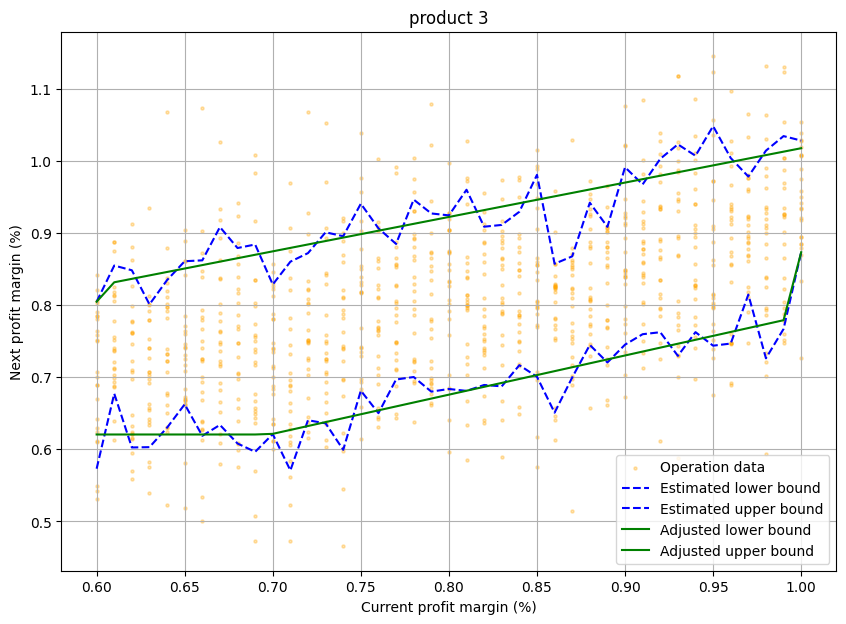

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 199 rows, 82 columns and 476 nonzeros
Model fingerprint: 0x1671eaf6
Model has 82 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [3e-02, 5e-02]
  QObjective range [5e-02, 5e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.01s
Presolved: 199 rows, 82 columns, 476 nonzeros
Presolved model has 82 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 82
 AA' NZ     : 9.300e+02
 Factor NZ  : 2.667e+03
 Factor Ops : 3.989e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time

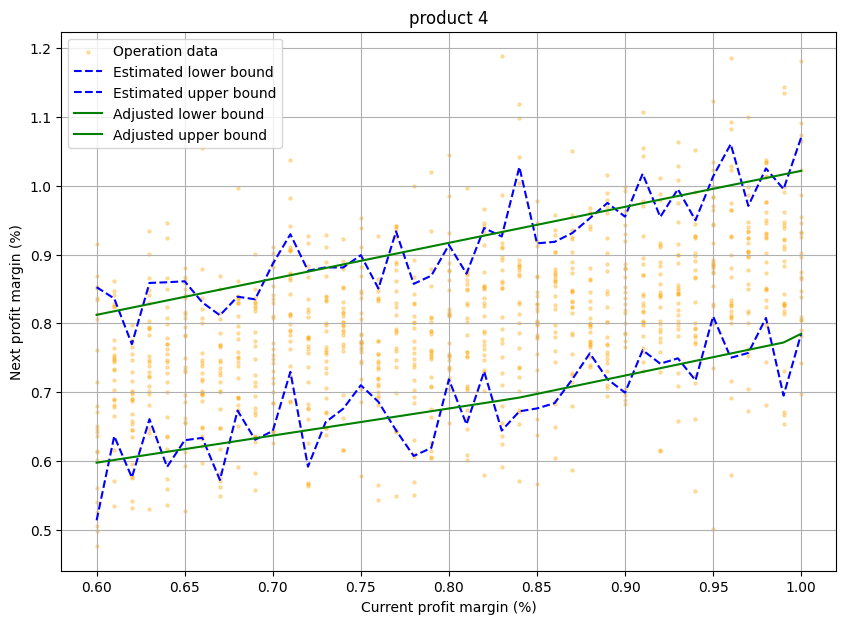

In [36]:
# 各 d に対応する変数を保存する辞書を作成
r_cur_bin_centers_list = []
r_lb_list = []
r_ub_list = []
weights_list = []
r_lb_adjusted_list = []
r_ub_adjusted_list = []
for d in range(M):
    # 境界の推定
    profit_rates_array = np.array(profit_rates_list[d])
    # 二重配列をNumPy配列に変換（必要に応じて）
    # profit_rates_array = np.array(profit_rates_array)

    r_cur_values = profit_rates_array[:, 0]
    r_next_values = profit_rates_array[:, 1]

    # delta の再定義（境界推定用）
    # delta_bounds はループ外で定義済みなので、ここでは不要です

    r_cur_bin_centers, r_lb, r_ub, weights = estimate_bounds(r_cur_values, r_next_values, q, delta)

    # データと推定値をプロット
    # plot_data(r_cur_values, r_next_values, r_cur_bin_centers, r_lb, r_ub, r_lb, r_ub, d)

    # bounds_adjustment 関数を使用して境界を調整
    r_lb_adjusted, r_ub_adjusted = bounds_adjustment(r_cur_bin_centers, r_lb, r_ub, weights)

    # 調整後の境界をプロット
    plot_data(
        r_cur_values, r_next_values, r_cur_bin_centers, r_lb, r_ub, r_lb_adjusted, r_ub_adjusted, d
    )

    r_cur_bin_centers_list.append(r_cur_bin_centers)
    r_lb_list.append(r_lb)
    r_ub_list.append(r_ub)
    weights_list.append(weights)
    r_lb_adjusted_list.append(r_lb_adjusted)
    r_ub_adjusted_list.append(r_ub_adjusted)


In [37]:
to_salse = 0

for i in range(len(r_lb_adjusted_list[0])):
    # print(i)
    pr = np.array(
        [
            r_lb_adjusted_list[0][i],
            r_lb_adjusted_list[1][i],
            r_lb_adjusted_list[2][i],
            r_lb_adjusted_list[3][i],
            r_lb_adjusted_list[4][i],
        ]
    ).reshape(-1, 1)
    a = sales_function(pr, alpha, beta)
    # print(a)
    to_salse += sum(a)

print(to_salse)


[947.47360555]


In [38]:
bounds_list = []
initial_bounds_list = []


for i in range(len(r_cur_bin_centers_list[d])):
    bounds = []
    initial_bounds = []
    for d in range(D):
        bounds.append(sorted((r_lb_list[d][i], r_cur_bin_centers_list[d][i])))
        initial_bounds.append(r_lb_list[d][i])
    bounds_list.append(bounds)
    initial_bounds_list.append(initial_bounds)
bounds_list


[[[0.5480704225753892, 0.6],
  [0.6, 0.6324915611158338],
  [0.5801638662734209, 0.6],
  [0.5731079644548083, 0.6],
  [0.5139619703150748, 0.6]],
 [[0.5848308080420486, 0.61],
  [0.61, 0.6282788964097292],
  [0.5949723869313039, 0.61],
  [0.61, 0.6772217513735986],
  [0.61, 0.6362247929018809]],
 [[0.62, 0.6241272728831692],
  [0.5374447342869165, 0.62],
  [0.62, 0.6315848254420866],
  [0.6025595223897464, 0.62],
  [0.5761613107903103, 0.62]],
 [[0.63, 0.6362824151693002],
  [0.5930544384674978, 0.63],
  [0.63, 0.6303270698040186],
  [0.6029805058133354, 0.63],
  [0.63, 0.6608632218070561]],
 [[0.5846847402670671, 0.64],
  [0.6125886853882974, 0.64],
  [0.6225423615785026, 0.64],
  [0.63007115580977, 0.64],
  [0.5915662478663395, 0.64]],
 [[0.5807361241765077, 0.65],
  [0.6387376511332796, 0.65],
  [0.6196778924828481, 0.65],
  [0.65, 0.662429817674722],
  [0.6302870667806996, 0.65]],
 [[0.616643181256794, 0.66],
  [0.6443769300929393, 0.66],
  [0.6350098312584567, 0.66],
  [0.61868919

In [39]:
r_lb_opt_list = [[] for _ in range(D)]
for r in range(len(r_cur)):
    opt_sales, opt_lb = predict_optimize_Neldar(D, X, y, initial_bounds_list[r], bounds_list[r])

    for d in range(D):
        r_lb_opt_list[d].append(opt_lb[d])

r_lb_opt_list


[[0.5999687638227739,
  0.6099831575275723,
  0.623999695457748,
  0.6362824151692996,
  0.64,
  0.65,
  0.6599999999999999,
  0.6695477212503931,
  0.68,
  0.6896798303784765,
  0.6999973446682151,
  0.7100000000000001,
  0.7199919029245743,
  0.7298994017836067,
  0.7399990184891632,
  0.7500000000000001,
  0.759931479087691,
  0.7699999787168434,
  0.78,
  0.7899999999999996,
  0.7999753876381731,
  0.81,
  0.8199999999999998,
  0.8300000000000002,
  0.8400000000000002,
  0.8499998993753832,
  0.8599999999999933,
  0.8700000000000002,
  0.8800000000000002,
  0.8900000000000002,
  0.8999999999999996,
  0.9100000000000003,
  0.9200000000000003,
  0.9299999999999982,
  0.9400000000000002,
  0.9500000000000003,
  0.9599999989710071,
  0.9700000000000002,
  0.9800000000000002,
  0.9900000000000003,
  1.0000000000000004],
 [0.6324915611158338,
  0.6282460514311575,
  0.6199394827746041,
  0.6298115100531658,
  0.6396322344761937,
  0.6387376511332796,
  0.6443769300929393,
  0.65700805378

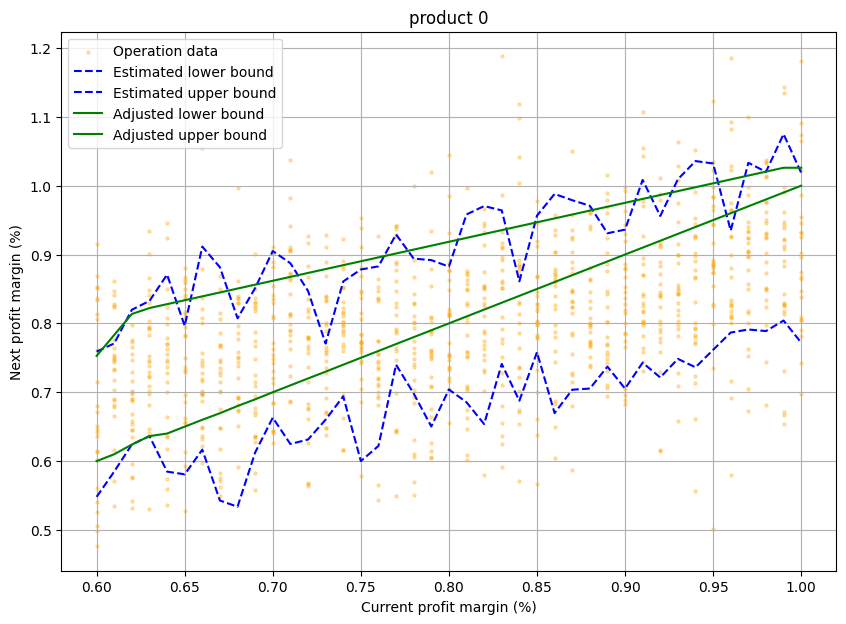

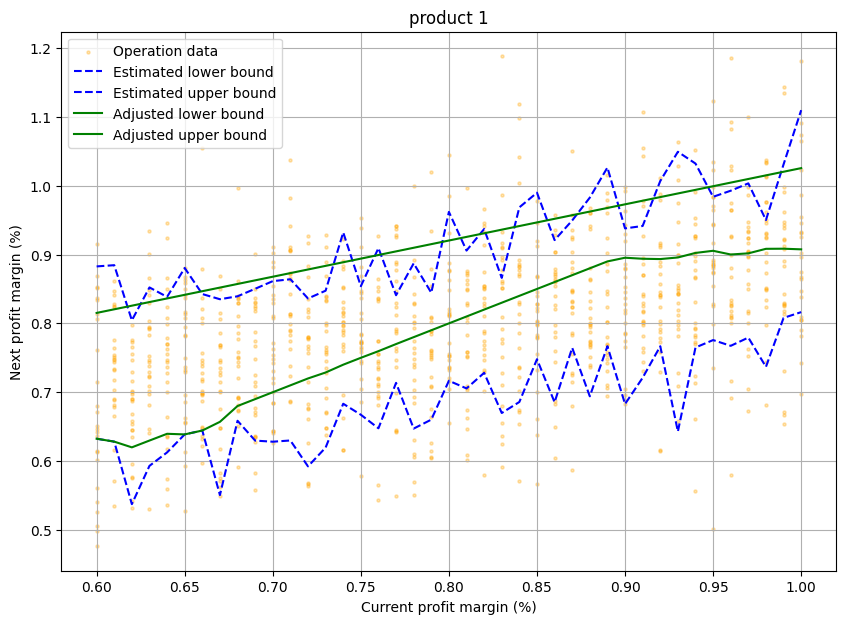

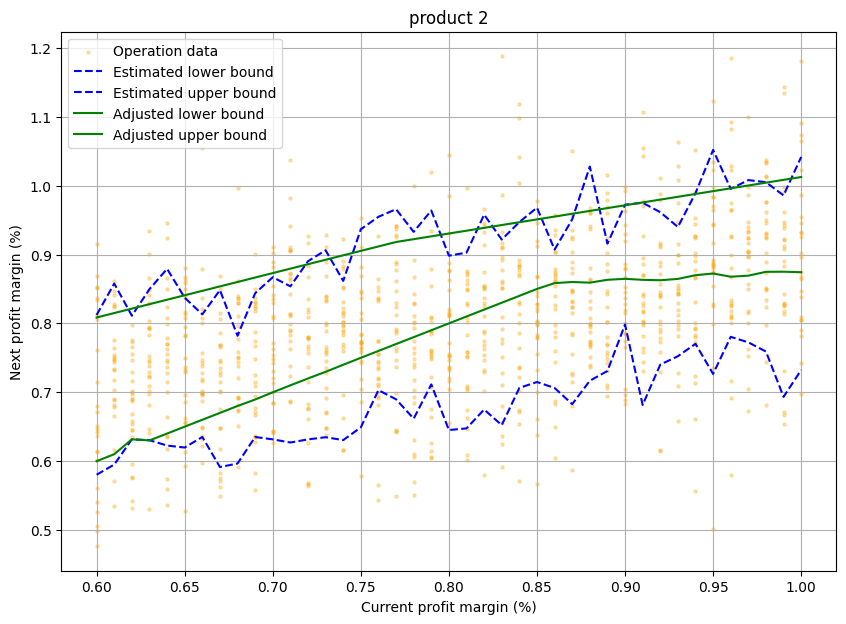

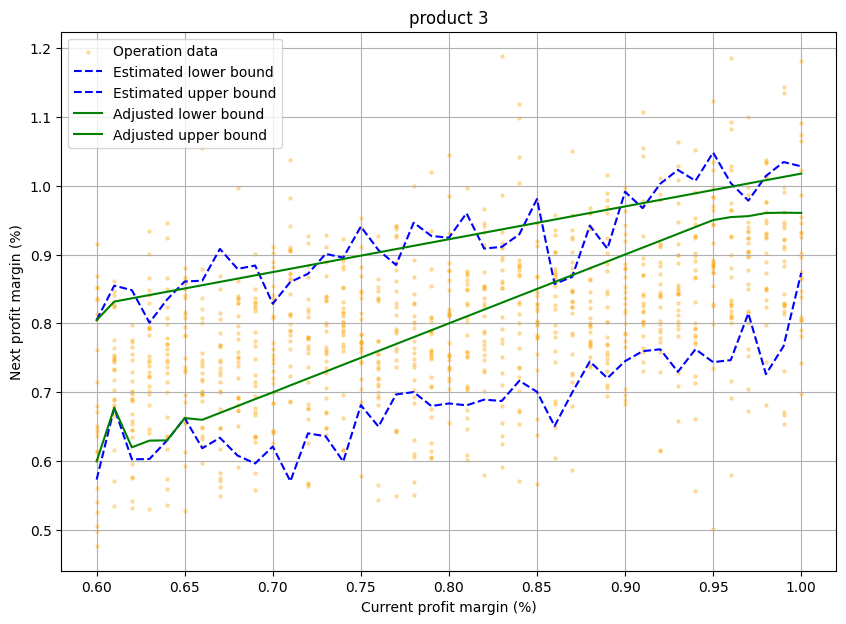

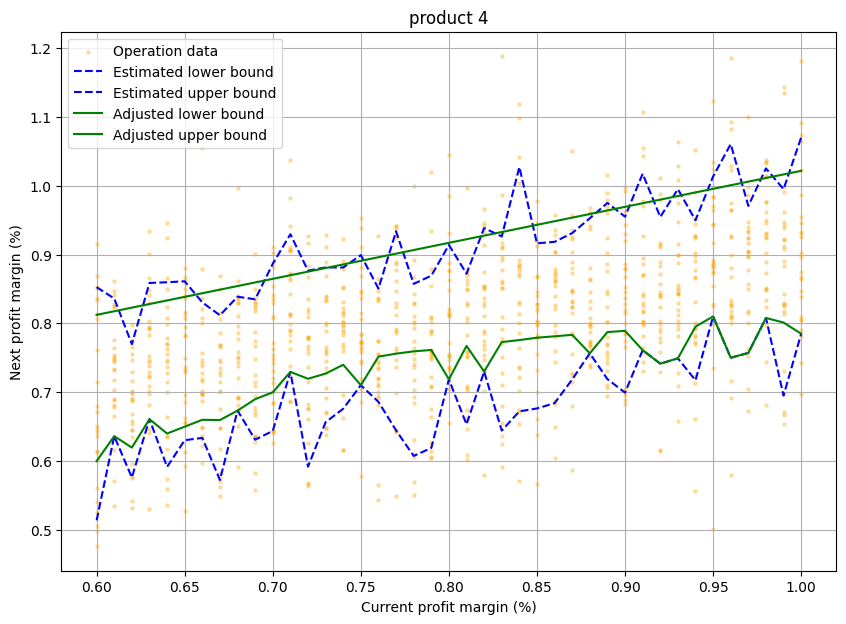

In [40]:
for d in range(D):
    r_cur_values = profit_rates_array[:, 0]
    r_next_values = profit_rates_array[:, 1]
    plot_data(
        r_cur_values,
        r_next_values,
        r_cur_bin_centers_list[d],
        r_lb_list[d],
        r_ub_list[d],
        r_lb_opt_list[d],
        r_ub_adjusted_list[d],
        d,
    )


In [41]:
len(r_lb_opt_list[0])

41

In [42]:
len(initial_bounds_list)

41